# Cell 1: Import necessary libraries and setup


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scipy import stats

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Using device: cuda


# Cell 2: Load Dataset and Initial EDA


Dataset loaded successfully.
Shape: (69999, 21)


C:\Users\kingv\AppData\Local\Temp\ipykernel_20380\2904487807.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FireAlarm', data=df, palette='coolwarm')


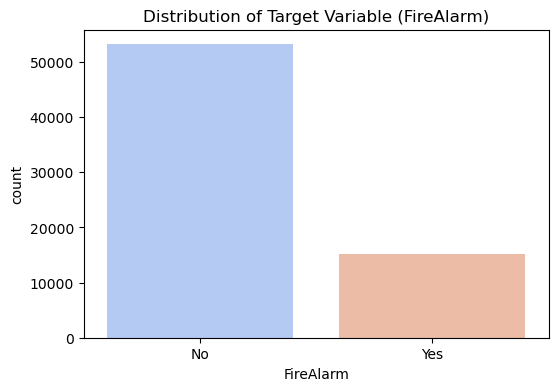


Missing values before processing:
162747


In [ ]:
try:
    df = pd.read_csv('../Datasets/Fire.csv', na_values=['NA'])
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'Fire.csv' not found. Please check the file path.")

plt.figure(figsize=(6, 4))
sns.countplot(x='FireAlarm', data=df, palette='coolwarm')
plt.title('Distribution of Target Variable (FireAlarm)')
plt.show()

print(df.isnull().sum().sum())

# Cell 3: Handling Missing Values (Imputation)


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

print("Imputing missing values...")

num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

print(f"Remaining missing values: {df.isnull().sum().sum()}")

Imputing missing values...
Remaining missing values: 0


# Cell 4: Encoding Categorical Features


In [ ]:
df_encoded = df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded '{col}': {len(le.classes_)} classes")

display(df_encoded.head())

Encoded 'Home-Loc': 49 classes
Encoded 'SteamDir': 16 classes
Encoded 'RedLightDir1': 16 classes
Encoded 'RedLightDir2': 16 classes
Encoded 'FireAlarm': 2 classes


,Home-Loc,HumidityMin,HumidityMax,TVOC,eCO2,N2ppm,SteamDir,SteamSpeed,RedLightDir1,RedLightDir2,...,H2-Sensor2,H2-Sensor3,H2-Sensor4,Visibility-Left-Sensor,Visibility-Right-Sensor,Cloud9am,Cloud3pm,TempMin,TempMax,FireAlarm
0,18,12.0,22.6,0.0,2.6,4.2,12,43.0,12,8,...,15.0,70.0,52.0,1017.7,1015.2,5.0,5.0,16.7,21.1,0
1,13,26.7,32.0,3.6,8.0,3.0,13,39.0,13,14,...,22.0,75.0,72.0,1007.6,1005.4,6.0,7.0,29.4,29.9,0
2,42,15.0,29.3,0.0,4.8,8.4,14,61.0,5,13,...,33.0,78.0,17.0,1007.8,1007.4,1.0,5.0,21.6,28.6,0
3,39,24.0,30.0,4.0,8.0,8.4,1,61.0,2,0,...,13.0,77.0,77.0,1010.1,1007.2,8.0,7.0,29.0,29.0,1
4,47,21.5,22.2,0.2,4.8,8.4,3,50.0,9,12,...,13.0,86.0,93.0,1011.7,1010.5,8.0,8.0,22.1,19.3,1


# Cell 5: Outlier Detection and Removal (Z-Score)


In [ ]:
z_scores = np.abs(stats.zscore(df_encoded))

threshold = 3

df_clean = df_encoded[(z_scores < threshold).all(axis=1)]

print(f"Original samples: {df_encoded.shape[0]}")
print(f"Samples after outlier removal: {df_clean.shape[0]}")
print(f"Removed: {df_encoded.shape[0] - df_clean.shape[0]} samples")

Original samples: 69999
Samples after outlier removal: 65664
Removed: 4335 samples


# Cell 6: Data Splitting and Normalization


In [ ]:
target_col = 'FireAlarm'
X = df_clean.drop(columns=[target_col]).values
y = df_clean[target_col].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print("Data normalized and split.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Data normalized and split.
Train shape: (52531, 20), Test shape: (13133, 20)


# Cell 7: Prepare PyTorch DataLoaders


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Cell 8: Helper Functions for Training and Plotting


In [ ]:

def train_model(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
        
        train_avg = running_train_loss / len(train_loader)
        test_avg = running_test_loss / len(test_loader)
        train_losses.append(train_avg)
        test_losses.append(test_avg)
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_avg:.4f} | Test Loss: {test_avg:.4f}")
            
    return train_losses, test_losses

def evaluate_model(model, X_test, y_test, title="Model"):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test.to(device))
        probs = torch.sigmoid(outputs)
        predictions = (probs >= 0.5).float().cpu()
        y_true = y_test.cpu()
    
    acc = accuracy_score(y_true, predictions)
    print(f"\n--- {title} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, predictions, target_names=['No Fire', 'Yes Fire']))
    
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'{title} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_loss(train_losses, test_losses, title="Loss Curve"):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

# Cell 9: Linear Separability Check (Single Layer Perceptron)


Training Perceptron...
Epoch 5/30 | Train Loss: 0.3616 | Test Loss: 0.3612
Epoch 10/30 | Train Loss: 0.3593 | Test Loss: 0.3590
Epoch 15/30 | Train Loss: 0.3585 | Test Loss: 0.3585
Epoch 20/30 | Train Loss: 0.3581 | Test Loss: 0.3578
Epoch 25/30 | Train Loss: 0.3578 | Test Loss: 0.3576
Epoch 30/30 | Train Loss: 0.3576 | Test Loss: 0.3576


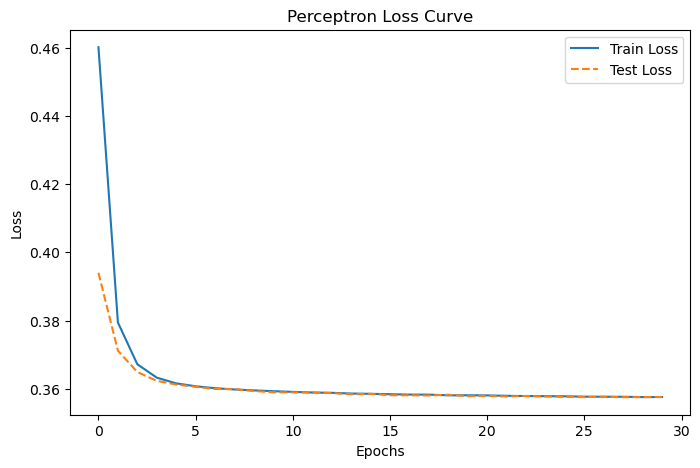


--- Perceptron Results ---
Accuracy: 0.8479

Classification Report:
              precision    recall  f1-score   support

     No Fire       0.87      0.95      0.91     10441
    Yes Fire       0.71      0.44      0.54      2692

    accuracy                           0.85     13133
   macro avg       0.79      0.70      0.73     13133
weighted avg       0.84      0.85      0.83     13133



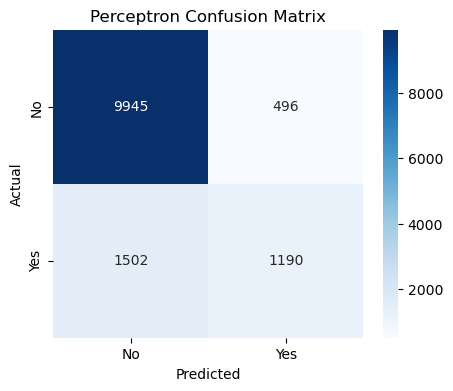

In [ ]:

class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x) 

# Initialize
input_dim = X_train.shape[1]
perceptron_model = Perceptron(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(perceptron_model.parameters(), lr=0.01)

print("Training Perceptron...")
p_train_loss, p_test_loss = train_model(perceptron_model, criterion, optimizer, train_loader, test_loader, epochs=30)

plot_loss(p_train_loss, p_test_loss, "Perceptron Loss Curve")
evaluate_model(perceptron_model, X_test_tensor, y_test_tensor, "Perceptron")

# Cell 10: MLP Design with Weighted Loss (Handling Imbalance)


Calculated Positive Weight: 3.88

Training Optimized MLP...
Epoch 5/40 | Train Loss: 0.7317 | Test Loss: 0.7372
Epoch 10/40 | Train Loss: 0.7210 | Test Loss: 0.7211
Epoch 15/40 | Train Loss: 0.7129 | Test Loss: 0.7191
Epoch 20/40 | Train Loss: 0.7049 | Test Loss: 0.7159
Epoch 25/40 | Train Loss: 0.7009 | Test Loss: 0.7141
Epoch 30/40 | Train Loss: 0.6935 | Test Loss: 0.7150
Epoch 35/40 | Train Loss: 0.6913 | Test Loss: 0.7147
Epoch 40/40 | Train Loss: 0.6883 | Test Loss: 0.7136


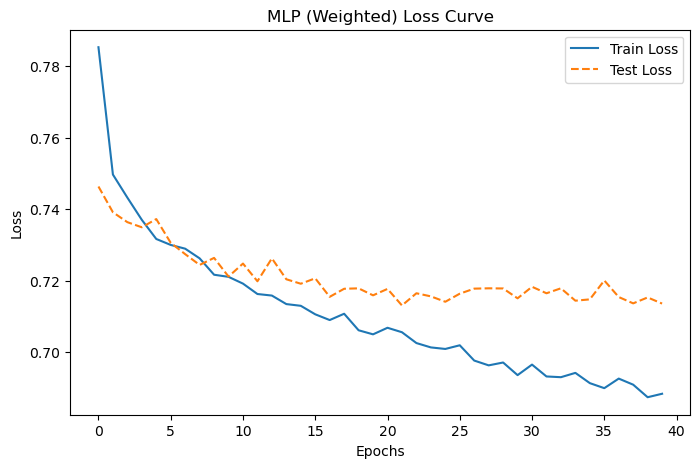


--- Optimized MLP Results ---
Accuracy: 0.7987

Classification Report:
              precision    recall  f1-score   support

     No Fire       0.93      0.80      0.86     10441
    Yes Fire       0.51      0.78      0.61      2692

    accuracy                           0.80     13133
   macro avg       0.72      0.79      0.74     13133
weighted avg       0.85      0.80      0.81     13133



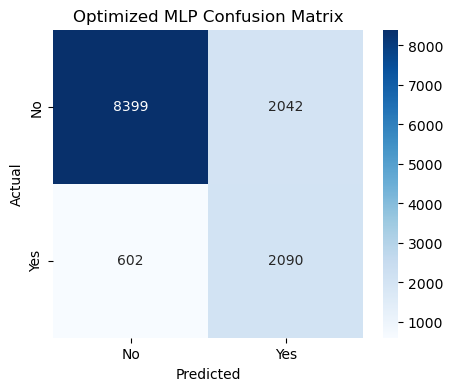

In [ ]:
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
pos_weight = num_neg / num_pos 
pos_weight_tensor = torch.tensor([pos_weight], device=device)

print(f"Calculated Positive Weight: {pos_weight:.2f}")

class OptimizedMLP(nn.Module):
    def __init__(self, input_dim):
        super(OptimizedMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

mlp_model = OptimizedMLP(input_dim).to(device)

criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

print("\nTraining Optimized MLP...")
m_train_loss, m_test_loss = train_model(mlp_model, criterion_weighted, optimizer_mlp, train_loader, test_loader, epochs=40)

plot_loss(m_train_loss, m_test_loss, "MLP (Weighted) Loss Curve")
evaluate_model(mlp_model, X_test_tensor, y_test_tensor, "Optimized MLP")